In [1]:
# Add word2vec to python path.
import sys
sys.path.append("external/word2vec")

In [2]:
# Load Config
config = {
    "use_cuda": True,
    
    "data_dir": "data/",
    "data_size": -1,
    "pre_trained_vocab_path": "models/skipgram/vocab.pt",
    "pre_train_embedding_path": "models/skipgram/best_val_model_4.27.pt",
    
    "learning_rate": 0.00025,
    "num_epochs": 64,
    
    "model_dir": "models/title-predictor/",
    "checkpoint_freq": 4,
}

In [3]:
import os
import time

# Data Processing.
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# PyTorch.
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import Vocab
from torchtext.data.utils import get_tokenizer

# Word2Vec.
from external.word2vec.utils.helper import (
    load_vocab,
)

# Title Predictor.
from title_predictor_model import TitlePredictor

# Plotting.
import matplotlib.pyplot as plt

/home/fangj/ttvp/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
plt.style.use("Solarize_Light2")

In [5]:
# Check CUDA availability.
if config["use_cuda"]:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
device

device(type='cuda')

In [6]:
# Check if model directory exists.
if not os.path.exists(config["model_dir"]):
    os.makedirs(config["model_dir"])

# Load Data

In [7]:
videoDf = pd.read_csv("data/usvideos_rm_dup.csv")
# Remove all nan view values.
videoDf = videoDf.dropna()
videoDf.head()

,Unnamed: 0,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,date_diff,video_link
0,40549,FchkqXEg0qs,2018-06-13,Nintendo @ E3 2018: Day 1,Nintendo,20.0,2018-06-13,"nintendo|""play""|""play nintendo""|""game""|""gamepl...",3238183.0,61841.0,3708.0,0.0,https://i.ytimg.com/vi/FchkqXEg0qs/default.jpg,True,False,False,ESRB Rating: RATING PENDING to Teen. Rating Pe...,0.0,https://www.youtube.com/watch?v=FchkqXEg0qs
1,5212,ZYCDNf1a-kY,2017-12-10,James Franco Audience Questions Monologue - SNL,Saturday Night Live,24.0,2017-12-10,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",9423.0,785.0,17.0,129.0,https://i.ytimg.com/vi/ZYCDNf1a-kY/default.jpg,False,False,False,Host James Franco takes questions from audienc...,0.0,https://www.youtube.com/watch?v=ZYCDNf1a-kY
3,20969,T3hXC5yNZOc,2018-03-01,Iggy Azalea - Savior ft. Quavo,iggyazaleamusicVEVO,10.0,2018-03-01,"Iggy|""Azalea""|""Savior""|""Island""|""Records""|""Hip...",285984.0,34129.0,1625.0,4219.0,https://i.ytimg.com/vi/T3hXC5yNZOc/default.jpg,False,False,False,Music video by Iggy Azalea performing Savior. ...,0.0,https://www.youtube.com/watch?v=T3hXC5yNZOc
4,13613,391JeKrI30w,2018-01-23,Watch the House floor live,Washington Post,25.0,2018-01-23,"breaking news video|""video updates""|""live vide...",57143.0,234.0,176.0,146.0,https://i.ytimg.com/vi/391JeKrI30w/default.jpg,False,False,False,"House votes to end government shutdown, sendin...",0.0,https://www.youtube.com/watch?v=391JeKrI30w
5,1208,n6xzsLDzyBk,2017-11-20,Lady Gaga - The Cure (Live at AMA's from Joann...,ladygagaarraza,23.0,2017-11-20,"American Music Awards|""AMA""|""Lady Gaga""|""The C...",18916.0,1425.0,28.0,180.0,https://i.ytimg.com/vi/n6xzsLDzyBk/default.jpg,False,False,False,Lady Gaga performing The Cure live from Joanne...,0.0,https://www.youtube.com/watch?v=n6xzsLDzyBk


In [8]:
# Dataset for twitter financial news text.
class YouTubeTitleViewDataset(Dataset):
    def __init__(self, df: pd.DataFrame, size = -1):
        self.titleDf = df
        # Shuffle and take a subset of the data.
        if size > 0:
            self.titleDf = self.titleDf.sample(frac=1).reset_index(drop=True)
            self.titleDf = self.titleDf[:size]
        else:
            self.titleDf = self.titleDf.sample(frac=1).reset_index(drop=True)
        
    def __len__(self):
        return len(self.titleDf)
    
    def __getitem__(self, idx):
        title = self.titleDf["title"][idx]
        view = self.titleDf["views"][idx]
        return str(title), view

    def __iter__(self):
        for i in range(len(self)):
            yield self[i]

In [9]:
# Create title dataset.
titleDataset = YouTubeTitleViewDataset(videoDf, size = config["data_size"])
len(titleDataset)

6230

In [10]:
# Split train and test dataset.
trainSet, valSet = train_test_split(titleDataset, test_size=0.2)
len(trainSet), len(valSet)

(4984, 1246)

In [11]:
titleDataset[0]

('New Gear for the NYC Office!! (+ How I Organize Footage)', 70551.0)

# Load Vocab and Tokenizer

In [12]:
if (config["pre_trained_vocab_path"]):
    vocab: Vocab = load_vocab(config["pre_trained_vocab_path"])
    vocabSize = len(vocab.get_stoi())
    print(f"Pretrained vocab size: {vocabSize}")
else:
    print(f"No vocab path provided.")

Pretrained vocab size: 11611


In [13]:
# Add SOS and EOS tokens.
vocab.append_token("<SOS>")
vocab.append_token("<EOS>")
vocabSize = len(vocab.get_stoi())
print(f"Vocab size: {vocabSize}")

Vocab size: 11613


In [14]:
# Get the english tokenizer.
tokenizer = get_tokenizer("basic_english", language="en")
tokenizer

<function torchtext.data.utils._basic_english_normalize(line)>

In [15]:
# Get the first sentence and view.
sentence, view = titleDataset[0]
print(sentence)
print(view)
# Tokenize the sentence.
tokenizedSentence: list = tokenizer(sentence)
tokenizedSentence.insert(0, "<SOS>")
tokenizedSentence.append("<EOS>")
print(tokenizedSentence)
# Convert the tokens to ids.
print(vocab(tokenizedSentence))

New Gear for the NYC Office!! (+ How I Organize Footage)
70551.0
['<SOS>', 'new', 'gear', 'for', 'the', 'nyc', 'office', '!', '!', '(', '+', 'how', 'i', 'organize', 'footage', ')', '<EOS>']
[11611, 122, 3397, 17, 4, 3027, 570, 14, 14, 35, 1572, 85, 3, 5970, 5490, 31, 11612]


# Model

In [16]:
# Loading pretrained embedding weight.
embeddingWeight = torch.load(config["pre_train_embedding_path"])["embeddings.weight"]
print(f"Embedding weight shape: {embeddingWeight.shape}")
# Create an embedding layer.
embedding = nn.Embedding(vocabSize, embeddingWeight.shape[1])
print(f"Embedding layer shape: {embedding.weight.shape}")
# Load pretrained embedding weight.
with torch.no_grad():
    embedding.weight.data[:embeddingWeight.shape[0]] = embeddingWeight
print(f"Pretrained embedding loaded. Embedding layer shape: {embedding.weight.shape}")

Embedding weight shape: torch.Size([11611, 300])
Embedding layer shape: torch.Size([11613, 300])
Pretrained embedding loaded. Embedding layer shape: torch.Size([11613, 300])


# Training

In [17]:
# Create model.
model = TitlePredictor(
    vocabSize,
    embeddingSize = embeddingWeight.shape[1],
    hiddenSize = 256,
    numLayers = 2,
    dropout = 0.5,
    embedding = embedding
)
model = model.to(device)

Using pretrained embedding.


In [18]:
# Setup loss function and optimizer.
lossFunction = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])

In [19]:
trainLosses = []
valLosses = []
startTime = time.time()
bestValLoss = float("inf")
bestValModel = None

# Train the model.
for epoch in range(config["num_epochs"]):
    print(f"Epoch: {epoch+1}/{config['num_epochs']}")
    # Train the model.
    trainLossVal = 0
    valLossVal = 0
    for i, (title, view) in enumerate(trainSet):
        # Tokenize the sentence.
        tokenizedSentence: list = tokenizer(title)
        tokenizedSentence.insert(0, "<SOS>")
        tokenizedSentence.append("<EOS>")
        # Convert the tokens to ids.
        tokenizedSentence = vocab(tokenizedSentence)
        # Convert to tensor.
        tokenizedSentence = torch.tensor(tokenizedSentence).to(device)
        # Reshape to [sentence length, 1]
        tokenizedSentence = tokenizedSentence.unsqueeze(1)
        # Get the view.
        view = torch.tensor([view]).to(device)
        # Get the natural log of the view.
        view = torch.log(view)
        # Reshape to [1]
        view = view.unsqueeze(0)
        # Forward pass.
        prediction = model(tokenizedSentence)
        # Compute loss.
        trainLoss = lossFunction(prediction, view.float())
        # Backward pass.
        optimizer.zero_grad()
        trainLoss.backward()
        # Update parameters.
        optimizer.step()
        # Add loss to train loss.
        trainLossVal += trainLoss.item()
        
        print(f"Sentence: {i+1}/{len(trainSet)}", end="\r")
    
    # Validate the model.
    with torch.no_grad():
        for i, (title, view) in enumerate(valSet):
            # Tokenize the sentence.
            tokenizedSentence: list = tokenizer(title)
            tokenizedSentence.insert(0, "<SOS>")
            tokenizedSentence.append("<EOS>")
            # Convert the tokens to ids.
            tokenizedSentence = vocab(tokenizedSentence)
            # Convert to tensor.
            tokenizedSentence = torch.tensor(tokenizedSentence).to(device)
            # Reshape to [sentence length, 1]
            tokenizedSentence = tokenizedSentence.unsqueeze(1)
            # Get the view.
            view = torch.tensor([view]).to(device)
            # Get the natural log of the view.
            view = torch.log(view)
            # reshape to [1]
            view = view.unsqueeze(0)
            # Forward pass.
            prediction = model(tokenizedSentence)
            # Compute loss.
            valLoss = lossFunction(prediction, view)
            # Add loss to validation loss.
            valLossVal += valLoss.item()
    
    avgTrainLoss = trainLossVal/len(trainSet)
    avgValLoss = valLossVal/len(valSet)
    
    # Print loss.
    print(f"Epoch: {epoch+1}/{config['num_epochs']}, Train Loss: {avgTrainLoss:.4f}, Val Loss: {avgValLoss:.4f}")
    
    trainLosses.append(avgTrainLoss)
    valLosses.append(avgValLoss)
    
    # Save the model with the lowest validation loss.
    if avgValLoss < bestValLoss:
        bestValLoss = avgValLoss
        bestValModel = model
        print("Best model saved.")
    
    # Save checkpoint.
    if (epoch+1) % config["checkpoint_freq"] == 0:
        checkpoint = {
            "model": model.state_dict(),
            "vocabSize": model.vocabSize,
            "embeddingSize": model.embeddingSize,
            "hiddenSize": model.hiddenSize,
            "numLayers": model.numLayers,
            "dropout": model.dropoutPr,
        }
        torch.save(checkpoint, f"{config['model_dir']}/checkpoint_{epoch+1}.pt")
        print(f"Checkpoint saved at epoch {epoch+1}.")
    
    # Calculate time.
    currTime = time.time()
    elapsedTime = currTime - startTime
    print(f"Elapsed time: {elapsedTime/60:.2f} minutes.")
    print(f"Average time per epoch: {elapsedTime/(epoch+1)/60:.2f} minutes.")
    print(f"Estimated time remaining: {(config['num_epochs'] - epoch - 1)*elapsedTime/(epoch+1)/60:.2f} minutes.")
        

Epoch: 1/64
Epoch: 1/64, Train Loss: 6.2518, Val Loss: 5.4018
Best model saved.
Elapsed time: 0.43 minutes.
Average time per epoch: 0.43 minutes.
Estimated time remaining: 27.12 minutes.
Epoch: 2/64
Epoch: 2/64, Train Loss: 4.0313, Val Loss: 4.5142
Best model saved.
Elapsed time: 0.89 minutes.
Average time per epoch: 0.44 minutes.
Estimated time remaining: 27.48 minutes.
Epoch: 3/64
Epoch: 3/64, Train Loss: 3.0620, Val Loss: 4.5556
Elapsed time: 1.34 minutes.
Average time per epoch: 0.45 minutes.
Estimated time remaining: 27.31 minutes.
Epoch: 4/64
Epoch: 4/64, Train Loss: 2.5954, Val Loss: 3.6701
Best model saved.
Checkpoint saved at epoch 4.
Elapsed time: 1.77 minutes.
Average time per epoch: 0.44 minutes.
Estimated time remaining: 26.62 minutes.
Epoch: 5/64
Epoch: 5/64, Train Loss: 2.1654, Val Loss: 3.6231
Best model saved.
Elapsed time: 2.22 minutes.
Average time per epoch: 0.44 minutes.
Estimated time remaining: 26.24 minutes.
Epoch: 6/64
Epoch: 6/64, Train Loss: 1.9221, Val Loss:

In [20]:
# Save the model.
torch.save({
    "model": bestValModel.state_dict(),
    "vocabSize": bestValModel.vocabSize,
    "embeddingSize": bestValModel.embeddingSize,
    "hiddenSize": bestValModel.hiddenSize,
    "numLayers": bestValModel.numLayers,
    "dropout": bestValModel.dropoutPr,
}, f"{config['model_dir']}/best_val_{bestValLoss:.2f}.pt")
# Save vocabulary.
torch.save(vocab, f"{config['model_dir']}/vocab.pt")
# Save the loss.
with open(f"{config['model_dir']}/loss.json", "w") as f:
    json.dump({
        "trainLosses": trainLosses,
        "valLosses": valLosses
    }, f)

# Plot the Loss

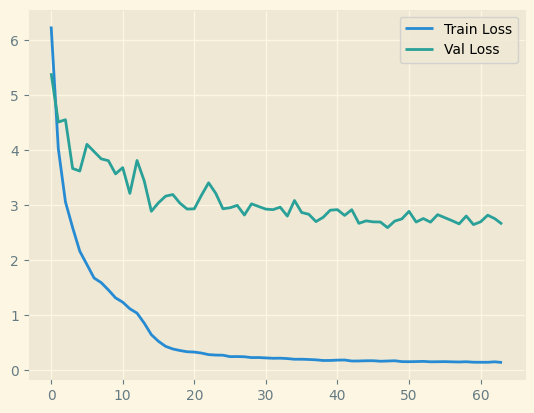

In [21]:
# Plot the loss.
plt.plot(trainLosses, label="Train Loss")
plt.plot(valLosses, label="Val Loss")
plt.legend()

In [22]:
# Sort the data by view.
videoDf = videoDf.sort_values(by="views", ascending=True)
videoDf.head()

,Unnamed: 0,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,date_diff,video_link
1454,14782,y6KYFcta4SE,2018-01-28,"1 dead, others injured after Ky. school shooting",Newsy,25.0,2018-01-23,"shooting|""kentucky""|""breaking news""|""u.s. news...",559.0,9.0,0.0,4.0,https://i.ytimg.com/vi/y6KYFcta4SE/default.jpg,False,False,False,Kentucky Gov. Matt Bevin confirmed there was a...,5.0,https://www.youtube.com/watch?v=y6KYFcta4SE
991,777,-JVITToppE0,2017-11-17,Coach Taggart Monday Presser Ahead of Arizona,GoDucksdotcom,17.0,2017-11-13,"Oregon|""Ducks""|""college athletics""|""college fo...",704.0,10.0,2.0,5.0,https://i.ytimg.com/vi/-JVITToppE0/default.jpg,False,False,False,Coach Taggart addresses the media ahead of the...,4.0,https://www.youtube.com/watch?v=-JVITToppE0
6006,14984,dQMZLXaa1L8,2018-01-29,Artwork Forge,Palo Alto Online,17.0,2018-01-10,[none],745.0,1.0,0.0,0.0,https://i.ytimg.com/vi/dQMZLXaa1L8/default.jpg,False,False,False,Artwork Forge II - an art installation created...,19.0,https://www.youtube.com/watch?v=dQMZLXaa1L8
377,12716,zeQaJGkFyqQ,2018-01-18,"Raw: 3 South Carolina Deputies, 1 Officer Shot",Associated Press,25.0,2018-01-16,"news|""associated press""|""ap""|""ap online""|""asso...",748.0,9.0,0.0,0.0,https://i.ytimg.com/vi/zeQaJGkFyqQ/default.jpg,True,False,False,Three deputies and one police officer were sho...,2.0,https://www.youtube.com/watch?v=zeQaJGkFyqQ
6352,160,qg0GdM60syI,2017-11-14,Huffy Metaloid Bicycle Commercial 1997,90s Commercials,27.0,2017-03-31,"90s commercials|""Huffy""",773.0,2.0,0.0,0.0,https://i.ytimg.com/vi/qg0GdM60syI/default.jpg,False,False,False,Anyone have one of those?,228.0,https://www.youtube.com/watch?v=qg0GdM60syI


In [23]:
# Get 100 evenly spaced indices.
indices = range(0, len(videoDf), len(videoDf)//100)
indices = list(indices)
# Get the title and view.
titles = videoDf["title"].iloc[indices].tolist()
views = videoDf["views"].iloc[indices].tolist()
len(titles), len(views)

(101, 101)

In [24]:
# Predict the views.
predictedViews = []
with torch.no_grad():
    for i, title in enumerate(titles):
        # Tokenize the sentence.
        tokenizedSentence: list = tokenizer(title)
        tokenizedSentence.insert(0, "<SOS>")
        tokenizedSentence.append("<EOS>")
        # Convert the tokens to ids.
        tokenizedSentence = vocab(tokenizedSentence)
        tokenizedSentence = torch.tensor(tokenizedSentence).to(device)
        # Reshape to [sentence length, 1]
        tokenizedSentence = tokenizedSentence.unsqueeze(1)
        # Convert to tensor.
        tokenizedSentence = torch.tensor(tokenizedSentence).to(device)
        # Forward pass.
        prediction = model(tokenizedSentence)
        # Get the view.
        predictedView = torch.exp(prediction).item()
        predictedViews.append(predictedView)
        print(f"Sentence: {i+1}/{len(titles)}", end="\r")
len(predictedViews)

/tmp/ipykernel_153040/1947743469.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenizedSentence = torch.tensor(tokenizedSentence).to(device)


101

In [25]:
titles[20], views[20], predictedViews[20]

('Roomba Rodeo', 110590.0, 28146.84765625)

In [26]:
# Convert views and predicted views to log scale.
logVies = np.log(views)
logPredictedViews = np.log(predictedViews)

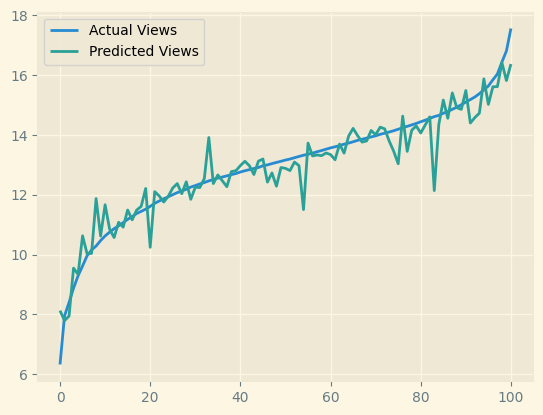

In [27]:
# Plot the predicted views and actual views.
plt, ax = plt.subplots()
ax.plot(logVies, label="Actual Views")
ax.plot(logPredictedViews, label="Predicted Views")
ax.legend()